# Pipeline for the anomaly detection on the SKAB using MSCRED

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [ ]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

sys.path.append("..")
from core.MSCRED import MSCRED
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
# hyperparameters selection
step_max = 5  # maximum step in ConvLSTM
gap_time = 1  # gap time between each segment
win_size = [5, 10, 30]  # window size of each segment
scale_n = len(win_size)
Q = 0.99  # quantile for upper control limit (UCL) selection

In [ ]:
def create_dataset(df, win_size, gap_time, step_max):
    data = np.array(df, dtype=np.float64)
    sensor_n = data.shape[1]
    data_all = []
    scale_n = len(win_size)
    # min-max normalization
    data = MinMaxScaler().fit_transform(data).T

    for win in win_size:
        matrix_all = []
        print(f"generating signature with window {win} ...")
        for t in range(win_size[-1], len(df), gap_time):
            matrix_t = np.zeros((sensor_n, sensor_n))
            for i in range(sensor_n):
                for j in range(i, sensor_n):
                    matrix_t[i][j] = np.inner(
                        data[i, t - win : t], data[j, t - win : t]
                    ) / (win)  # rescale by win
                    matrix_t[j][i] = matrix_t[i][j]
            matrix_all.append(matrix_t)
        data_all.append(matrix_all)

    data_all = np.transpose(data_all, (1, 2, 3, 0))

    print("create dataset ...")

    dataset = data_all[:step_max]
    for i in range(step_max + 1, len(data_all) + 1):
        dataset = np.append(dataset, data_all[i - step_max : i], axis=0)

    return dataset.reshape([-1, step_max, sensor_n, sensor_n, scale_n])

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
mses = []
x = 0
for df in list_of_df:
    x += 1
    print(f"----------------------dataset {x}--------------------------------")
    df = df.drop(["anomaly", "changepoint"], axis=1)
    sensor_n = df.shape[1]
    dataset = create_dataset(df, win_size, gap_time, step_max)
    train_stop = (500 - win_size[-1]) // gap_time - step_max

    X_train = dataset[:train_stop]
    Y_train = dataset[:train_stop, -1]
    X_test = dataset[train_stop:]
    Y_test = dataset[train_stop:, -1]

    PARAMS = [sensor_n, scale_n, step_max]

    # model defining and fitting
    model = MSCRED(PARAMS)
    model.fit(X_train, Y_train)

    # results predicting
    Y_pred = model.predict(dataset)
    resid_mat = dataset[:, -1] - Y_pred
    mse = np.mean(np.square(resid_mat), axis=(1, 2))
    t = df.index[win_size[-1] :: gap_time][step_max - 1 :]
    mse_df = pd.DataFrame(mse, index=t, columns=[f"win_{i}" for i in win_size])
    mses.append(mse_df)

    UCL = mse_df[:train_stop].quantile(Q) * 3 / 2
    prediction = (
        pd.DataFrame((mse_df > UCL), t).fillna(0).any(axis=1).astype(int)
    )

    # # plot
    # fig, axes = plt.subplots(1, len(win_size), figsize=(24, 3))
    # fig.suptitle(f"dataset №{x}")
    # for i, col in enumerate(mse_df.columns):
    #     ax = axes.flatten()[int(i)]
    #     ax.hlines(UCL[col], t[0], t[-1], "r")
    #     mse_df[col].plot(ax=ax)
    #     ax.legend()

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

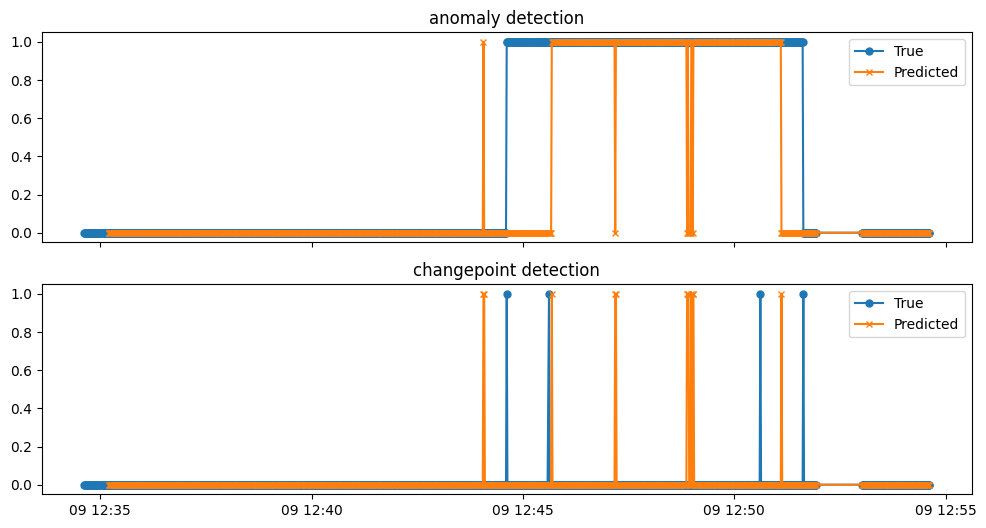

In [ ]:
# [donotremove]
true_outlier = [df.anomaly for df in list_of_df]
true_cp = [df.changepoint for df in list_of_df]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 12.19 %
Missing Alarm Rate 28.99 %
F1 metric 0.74


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 54
A number of FPs = 146
Average time 0 days 00:00:30.389333333


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  1.73
LowFP  -  -29.72
LowFN  -  15.62
